In [1]:
!pip install --upgrade gensim==4.1.2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 24.1 MB 124.2 MB/s 
  Attempting uninstall: gensim
    Found existing installation: gensim 3.6.0
    Uninstalling gensim-3.6.0:
      Successfully uninstalled gensim-3.6.0


In [2]:
import numpy as np
import random
import os
import string
import nltk
import gensim
import tensorflow
import keras as tf
import pickle

import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns

from google.colab import drive

from tensorflow.keras.utils import to_categorical 
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
from gensim.models import Word2Vec
from keras.preprocessing import text, sequence
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, Dropout, Reshape, Bidirectional
from imblearn.under_sampling import RandomUnderSampler

nltk.download('punkt')

tf.device('/device:GPU:0')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [3]:
RANDOM_SEED = 12
MAX_FEATURES = 200000
EMBEDDINGS_DIM = 100
MAX_DOC_LEN = 1000

os.environ['PYTHONHASHSEED'] = str(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)
tensorflow.random.set_seed(RANDOM_SEED)

ROOTDIR = '/content/drive/MyDrive/Pós/discursos/'

from google.colab import drive
drive.mount('/content/drive')

ESPECTROS = ('esquerda', 'centro', 'direita')

Mounted at /content/drive


In [4]:
MIN_TAM = 250
MAX_TAM = 1000
LEGISLATURA = 56

df_treino = pd.read_json(ROOTDIR + f'data/treino_discurso_{MIN_TAM}_{MAX_TAM}_{LEGISLATURA}.json')
df_teste = pd.read_json(ROOTDIR + f'data/teste_discurso_{MIN_TAM}_{MAX_TAM}_{LEGISLATURA}.json')

In [5]:
df_treino.sexo.value_counts()

M    12538
F     2703
Name: sexo, dtype: int64

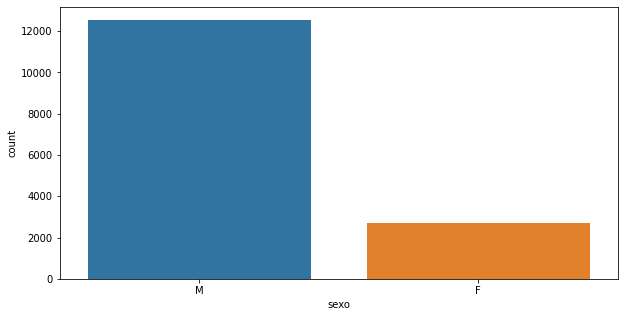

In [6]:
plt.figure(figsize=(10, 5))
sns.countplot(x = 'sexo' , data = df_treino, order = ('M', 'F'))
plt.show()

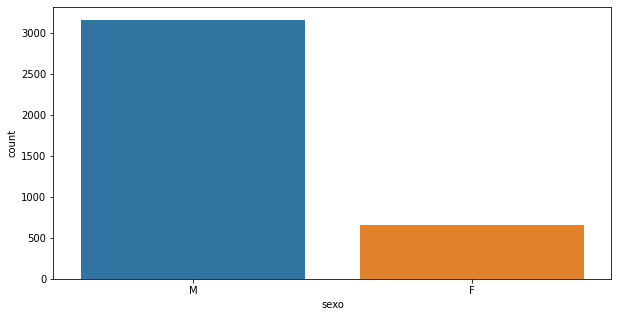

In [7]:
plt.figure(figsize=(10, 5))
sns.countplot(x = 'sexo' , data = df_teste, order = ('M', 'F'))
plt.show()

In [8]:
tokenizer = text.Tokenizer(num_words=MAX_FEATURES)
tokenizer.fit_on_texts(pd.concat((df_treino, df_teste))['tokens'])

In [9]:
labeler = LabelEncoder()
labeler.fit(df_treino['sexo'])

LabelEncoder()

In [10]:
X_treino = df_treino['tokens']
X_teste = df_teste['tokens']

X_treino = tokenizer.texts_to_sequences(X_treino)
X_treino = sequence.pad_sequences(X_treino, maxlen=MAX_DOC_LEN)

X_teste = tokenizer.texts_to_sequences(X_teste)
X_teste = sequence.pad_sequences(X_teste, maxlen=MAX_DOC_LEN)

In [11]:
Y_treino = df_treino['sexo']
Y_teste = df_teste['sexo']

Y_treino = to_categorical(labeler.transform(Y_treino), 2, dtype='float32')
Y_teste = to_categorical(labeler.transform(Y_teste), 2, dtype='float32')

In [12]:
w2v = Word2Vec.load(ROOTDIR + f'data/camares.{EMBEDDINGS_DIM}.w2v')

embeddings_mean, embeddings_std = w2v.wv.vectors.mean(), w2v.wv.vectors.std()

embeddings_matrix = np.random.normal(embeddings_mean, embeddings_std, size=(MAX_FEATURES+1, EMBEDDINGS_DIM))

for word, i in tokenizer.word_index.items():
    if i > MAX_FEATURES: continue
    try:
      embeddings_matrix[i] = w2v.wv[word]
    except KeyError:
      pass

In [13]:
BATCH_SIZE = 200
EPOCHS = 250
PATIENCE_LR = 25
PATIENCE_ES = 50
FACTOR = 0.25
MIN_LR = 0.00000001
# PLATEAU_MONITOR = 'val_loss'
PLATEAU_MONITOR = 'val_categorical_crossentropy'
# PLATEAU_MONITOR = 'val_categorical_accuracy'
LSTM_LAYER1_SIZE = EMBEDDINGS_DIM
LSTM_LAYER2_SIZE = EMBEDDINGS_DIM
LAYER1_DROPOUT_RATE = 0.1
LAYER2_DROPOUT_RATE = 0.25
RECURRENT_DROPOUT_RATE = 0.2
DENSE_LAYER1_SIZE = EMBEDDINGS_DIM
DENSE_LAYER1_DROPOUT_RATE = 0.5
DENSE_LAYER2_SIZE = EMBEDDINGS_DIM
DENSE_LAYER2_DROPOUT_RATE = 0.5
DENSE_LAYER1_FUNCTION = 'tanh'
DENSE_LAYER2_FUNCTION = 'tanh'
OUTPUT_LAYER_SIZE = 2
OUTPUT_LAYER_FUNCTION = 'softmax'
LEARNING_RATE = 0.0001
OPTIMIZER = tensorflow.keras.optimizers.Adam
# OPTIMIZER = tensorflow.keras.optimizers.Nadam
LOSS_FUNCTION = 'categorical_crossentropy'
# LOSS_FUNCTION = 'poisson'
METRIC_FUNCTIONS = ['categorical_accuracy', 'categorical_crossentropy']
VALIDATION_SPLIT_RATE = 0.2


#  Init model
model = Sequential()

# INPUT
model.add(Embedding(MAX_FEATURES+1, output_dim = EMBEDDINGS_DIM, weights = [embeddings_matrix], input_length = MAX_DOC_LEN, trainable = True, mask_zero=True))

# LSTM 1
model.add(Bidirectional(LSTM(LSTM_LAYER1_SIZE, return_sequences = True,  dropout = LAYER1_DROPOUT_RATE)))

# LSTM 2
model.add(Bidirectional(LSTM(LSTM_LAYER2_SIZE, dropout = LAYER2_DROPOUT_RATE, recurrent_dropout = RECURRENT_DROPOUT_RATE)))

# Dense 1
model.add(Dense(units = DENSE_LAYER1_SIZE, activation = DENSE_LAYER1_FUNCTION))
model.add(Dropout(DENSE_LAYER1_DROPOUT_RATE))

# Dense 2
model.add(Dense(DENSE_LAYER2_SIZE))

# Output
model.add(Dense(units = OUTPUT_LAYER_SIZE, activation = OUTPUT_LAYER_FUNCTION))

# Compile
model.compile(optimizer = OPTIMIZER(learning_rate = LEARNING_RATE), loss = LOSS_FUNCTION, metrics = METRIC_FUNCTIONS)

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 1000, 100)         20000100  
                                                                 
 bidirectional (Bidirectiona  (None, 1000, 200)        160800    
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 200)              240800    
 nal)                                                            
                                                                 
 dense (Dense)               (None, 100)               20100     
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 dense_1 (Dense)             (None, 100)               1

In [16]:
callbacks = [
  ReduceLROnPlateau(monitor = PLATEAU_MONITOR, patience = PATIENCE_LR, verbose = 2, factor = FACTOR, min_lr = MIN_LR),
  EarlyStopping(patience = PATIENCE_ES, verbose = True)             
]

if not os.path.isfile(ROOTDIR + f'data/classificador_discurso_genero_{LEGISLATURA}.dat'):

  history = model.fit(X_treino, Y_treino, batch_size = BATCH_SIZE, validation_split = VALIDATION_SPLIT_RATE, epochs = EPOCHS, callbacks = callbacks)

  with open(ROOTDIR + f'data/classificador_discurso_genero_{LEGISLATURA}.dat', 'wb') as fp:
    pickle.dump(model, fp)

  df_history = pd.DataFrame(history.history)
  df_history.to_json(ROOTDIR + f'data/history_classificador_discurso_genero_{LEGISLATURA}.json')

else:

  with open(ROOTDIR + f'data/classificador_discurso_genero_{LEGISLATURA}.dat', 'rb') as fp:
    model = pickle.load(fp)

  df_history = pd.read_json(ROOTDIR + f'data/history_classificador_discurso_genero_{LEGISLATURA}.json')

477/477 [==============================] - 426s 881ms/step - loss: 0.0561 - categorical_accuracy: 0.9900 - categorical_crossentropy: 0.0561
Acuracia de treinamento: 99.00 %
120/120 [==============================] - 105s 872ms/step - loss: 0.3642 - categorical_accuracy: 0.9402 - categorical_crossentropy: 0.3642
Acuracia de teste: 94.02 %


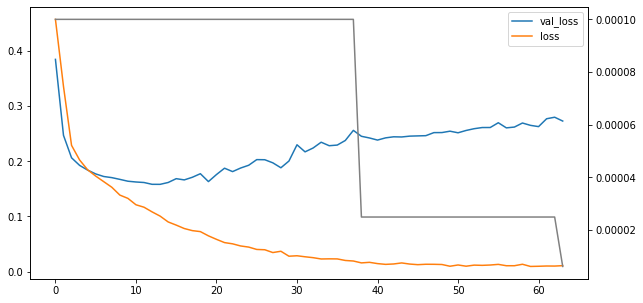

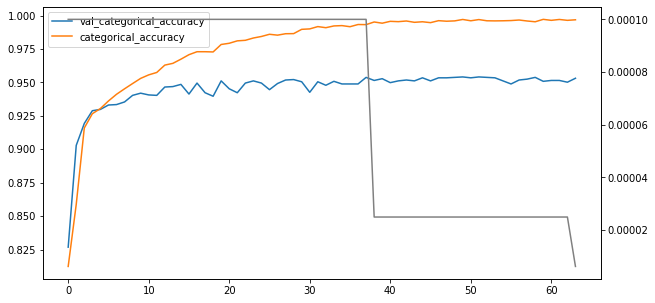

In [17]:
ax = df_history[['val_loss', 'loss']].plot(figsize=(10, 5))
df_history['lr'].plot(ax=ax.twinx(), color='gray')

ax = df_history[['val_categorical_accuracy', 'categorical_accuracy']].plot(figsize=(10, 5))
df_history['lr'].plot(ax=ax.twinx(), color='gray')

print("Acuracia de treinamento: {:.2f} %".format(model.evaluate(X_treino, Y_treino)[1]*100))
print("Acuracia de teste: {:.2f} %".format(model.evaluate(X_teste, Y_teste)[1]*100))

In [18]:
previsto = labeler.inverse_transform(np.argmax(model.predict(X_teste[0:]), axis=1))

In [20]:
real = labeler.inverse_transform(np.argmax(Y_teste[0:], axis=1))

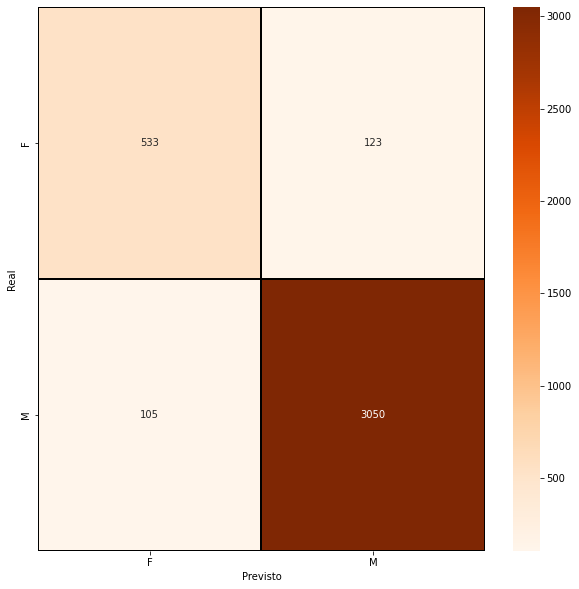

In [22]:
cm = confusion_matrix(real, previsto)
labels = labeler.classes_
cm = pd.DataFrame(cm, index = labels, columns = labels)

plt.figure(figsize = (10, 10))
sns.heatmap(cm, cmap= "Oranges", linecolor = 'black', linewidth = 1, annot = True, fmt='', xticklabels = labels, yticklabels = labels)
plt.xlabel("Previsto")
plt.ylabel("Real")
plt.show()